In [50]:
import sys
sys.version

'2.7.11 |Anaconda 2.4.1 (x86_64)| (default, Dec  6 2015, 18:57:58) \n[GCC 4.2.1 (Apple Inc. build 5577)]'

In [51]:
import os
import time
import math

import numpy as np
import scipy as sp
from scipy import sparse

from collections import Counter

try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import LabelKFold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier

import pickle
from sklearn.externals import joblib

from tabulate import tabulate

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')

<div class="alert alert-info">
<p><strong>GENERAL SETUP</strong></p>
</div>

**Common functions**

In [52]:
def count_files(directory):
    '''
    Counts number of (valid) files in a given directory.
    '''
    
    result = 0
    
    # loop through each file in the directory
    for datafile in os.listdir(directory):

        # move on - no data here
        if datafile == '.DS_Store':
            continue
        else:
            result += 1
            
    return result

In [53]:
def write_predictions(predictions, ids, outfile):
    '''
    Writes predictions in the required format.
    
    Assumes len(predictions) == len(ids), and that predictions[i] is the
    index of the predicted class with the malware_classes list above for 
    the executable corresponding to ids[i].
    
    If it already exists, outfile will be overwritten.
    '''
    
    # open file for outputing
    with open(outfile,'w+') as f:
        
        # write header
        f.write('Id,Prediction\n')
        
        # write predictions
        for i, history_id in enumerate(ids):
            f.write('%s,%d\n' % (history_id, predictions[i]))

In [54]:
def grid_search(model, parameters, train_x, train_y, folds=5, score_func=None, show_results=False):
    '''
    Generic function that is used to run n-fold cross-validation and select model
    parameters that minimize out-of-sample loss.
    
    From SKLearn documentation:
    By default, parameter search uses the score function of the estimator to evaluate a parameter setting.
    These are the sklearn.metrics.accuracy_score for classification and sklearn.metrics.r2_score for regression.
    
    Inputs
    ----------
    model: Any Scikit Learn predictive model
    parameters: Dictionary containing the parameters to be searched over
    train_x: Dataframe containing training set X-variables
    train_y: Dataframe containing training set Y-variables
    folds: Number of folds in cross-validation (default=5)
    score_func: Score function that can be used in evaluating parameters (default=None)
    '''
    
    # parameterize model (based on whether default scoring function is used)
    if score_func is None:
        model_xval = GridSearchCV(model, param_grid=parameters, cv=folds)
    else:
        model_xval = GridSearchCV(model, param_grid=parameters, cv=folds, scoring=score_func)
        
    # fit model
    model_xval.fit(train_x, train_y)
    
    # show results for each parameter combination
    if show_results:
        print 'Grid scores'
        print '----------'
        for g in model_xval.grid_scores_:
            print g
        print '----------'
        
    # return optimal model parameters
    return model_xval.best_estimator_

In [55]:
def fit_model(model, train_x, train_y, test_x, test_y, use_test=True):
    '''
    Generic function that is used to fit a model and compute out-of-sample accuracy.
    
    Inputs
    ----------
    model: Any Scikit Learn predictive model (with or without custom parameters)
    train_x: Dataframe containing training set X-variables
    train_y: Dataframe containing training set Y-variables
    train_x: Dataframe containing test set X-variables
    train_y: Dataframe containing test set Y-variables
    debug: Determines whether model results are displayed or not
    '''
    # fit model
    model.fit(train_x, train_y)
    
    # calculate training set accuracy
    train_acc = accuracy_score(train_y, model.predict(train_x))
    
    # calculate test set accuracy
    if use_test:
        test_acc = accuracy_score(test_y, model.predict(test_x))
    else:
        test_acc = None
        
    # print results
    if use_test:
        print model
        print '----------'
        print 'Training set accuracy = %0.4f' % train_acc
        print 'Validation set accuracy = %0.4f' % test_acc
        print '----------'
    
    # return fitted model and training/test accuracy
    return model, train_acc, test_acc

**Common variables**

In [56]:
# class labels (malaware classes)
malware_classes = ['Agent', 'AutoRun', 'FraudLoad', 'FraudPack', 'Hupigon', 'Krap',
                   'Lipler', 'Magania', 'None', 'Poison', 'Swizzor', 'Tdss',
                   'VB', 'Virut', 'Zbot']

In [57]:
# XML tags (we can skip these)
xml_tags = ['processes']

In [69]:
# keep track of all calls/tags in parsed XML
call_set = set([])

In [59]:
# file locations
TRAIN_DIR = 'data/train'
TEST_DIR = 'data/test'

In [60]:
# number of files per directory
train_files = count_files(TRAIN_DIR)
test_files = count_files(TEST_DIR)
valid_files = int(train_files * 0.8)
print train_files, test_files

3086 3724


<div class="alert alert-info">
<p><strong>FEATURE ENGINEERING</strong></p>
</div>

**Count number of all calls**

In [61]:
def call_feats_all(tree):
    '''
    Sample feature engineering function.
    Returns the number of system specific calls made by the programs.
    '''

    # keep track of calls
    call_counter = {}

    # loop through all calls/tags in the XML file
    for el in tree.iter():
        
        # extract the call/tag name
        call = el.tag
        
        # count the number of calls to each tag
        if call not in call_counter:
            call_counter[call] = 0
        else:
            call_counter[call] += 1

    # initialize the feature array (1 x D)        
    call_feat_array = np.zeros(num_calls)
    
    # loop through the calls we are looking for
    for i, call in enumerate(call_set):
        
        # update counter with the number of times the call was seen
        if call in call_counter:
            call_feat_array[i] = call_counter[call]
        else:
            call_feat_array[i] = 0

    # return feature array (1 x D)
    return call_feat_array

**Count percentage of all calls**

In [62]:
def call_feats_all_perc(tree):
    '''
    Sample feature engineering function.
    Returns the number of system specific calls made by the programs.
    '''

    # keep track of calls
    call_counter = {}
    
    # loop through all calls/tags in the XML file
    for el in tree.iter():
        
        # extract the call/tag name
        call = el.tag
        
        # count the number of calls to each tag
        if call not in call_counter:
            call_counter[call] = 0
        else:
            call_counter[call] += 1
            
    # initialize the feature array (1 x D)        
    call_feat_array = np.zeros(num_calls)
    
    # loop through the calls we are looking for
    for i, call in enumerate(call_set):
        
        # update counter with the number of times the call was seen
        if call in call_counter:
            call_feat_array[i] = call_counter[call]
        else:
            call_feat_array[i] = 0
            
    # convert to percentage
    call_feat_array = call_feat_array / call_feat_array.sum()

    # return feature array (1 x D)
    return call_feat_array

**Count number and percentage of all calls**

In [63]:
def call_feats_all_count_perc(tree):
    '''
    Sample feature engineering function.
    Returns the number of system specific calls made by the programs.
    '''

    # keep track of calls
    call_counter = {}
    
    # loop through all calls/tags in the XML file
    for el in tree.iter():
        
        # extract the call/tag name
        call = el.tag
        
        # count the number of calls to each tag
        if call not in call_counter:
            call_counter[call] = 0
        else:
            call_counter[call] += 1
            
    # initialize the feature array (1 x 2D)        
    call_feat_array = np.zeros(2 * num_calls)
    
    # loop through the calls we are looking for
    for i, call in enumerate(call_set):
        
        # update counter with the number of times the call was seen
        if call in call_counter:
            call_feat_array[i] = call_counter[call]
        else:
            call_feat_array[i] = 0
            
    # add percentages
    call_feat_array[num_calls:] = (call_feat_array[:num_calls] / call_feat_array[:num_calls].sum()).copy()

    # return feature array (1 x D)
    return call_feat_array

**Generic functions for processing files (do not modify)**

In [70]:
def add_to_set(tree):
    '''
    Keeps track of all seen call types.
    '''
    
    # loop through all calls/tags in the XML file
    for el in tree.iter():
        
        # extract the call/tag name
        call = el.tag
        
        # avoid known tags without information
        if call not in xml_tags:
        
            # update the list of call types
            call_set.add(call)

In [71]:
def get_all_calls(direc):
    '''
    Creates set of all possible calls - consistent reference for various functions.   
    '''
    
    call_set = set([])
    
    # loop through each file in the directory
    for datafile in os.listdir(direc):
        
        # move on - no data here
        if datafile == '.DS_Store':
            continue

        # parse file as an xml document
        tree = ET.parse(os.path.join(direc,datafile))
        
        # keept track of all calls/tags we have seen
        add_to_set(tree)

In [72]:
def create_data_matrix(fteng_fn, direc='data/train', start_index=-1, end_index=4000):
    '''
    Creates X and Y matrices based on the files present in a given directory.
    
    By default, all files will be processed, but a subset can be specified for
    faster testing or for training-validation splits.    
    '''

    # initialize X (feature) matrix (N x D)
    X = None
    
    # initialize Y (class) matrix (N x 1)
    classes = []
    
    # keep track of all file id's processed
    ids = []
    
    # keep track of the index of the file that is being processed
    # only really relevant when using a sub-set of the data
    i = -1
    
    # loop through each file in the directory
    for datafile in os.listdir(direc):
        
        # move on - no data here
        if datafile == '.DS_Store':
            continue

        # check that we are in bounds
        i += 1
        if i < start_index:
            continue
        if i >= end_index:
            break

        # extract id and true class (if available) from filename
        id_str, clazz = datafile.split('.')[:2]
        
        # keep track of all file id's processed
        ids.append(id_str)
        
        # add target class if this is training data
        try:
            classes.append(malware_classes.index(clazz))

        except ValueError:
            # we should only fail to find the label in our list of malware classes
            # if this is test data, which always has an 'X' label
            assert clazz == 'X'
            classes.append(-1)

        # parse file as an xml document
        tree = ET.parse(os.path.join(direc,datafile))
        
        # this is where features get created
        this_row = fteng_fn(tree)
        
        # add features to X matrix
        if X is None:
            X = this_row
        else:
            X = np.vstack((X, this_row))

    # return X (N x D), Y (N x 1), list of id's parsed
    return X, np.array(classes), ids

**Test feature extraction on a small number of files**

In [74]:
# get list of all calls (may take a few minutes)
get_all_calls(TRAIN_DIR)

# number of unique calls
num_calls = len(call_set)

In [68]:
# extract data/create features
# modify fteng_fn to test a different function
X_dev, Y_dev, dev_ids = create_data_matrix(
    fteng_fn=call_feats_all_count_perc, direc=TRAIN_DIR, start_index=0, end_index=5)

print X_dev.shape, Y_dev.shape

(5, 210) (5,)


<div class="alert alert-info">
<p><strong>DATAFRAMES FOR PREDICTION</strong></p>
</div>

**Create set of all possible calls**

In [21]:
start = time.time()

# get list of all calls (may take a few minutes)
get_all_calls(TRAIN_DIR)

# number of unique calls
num_calls = len(call_set)

print '%d unique calls' % num_calls
print '----------'
print '%0.1f seconds runtime' % (time.time() - start)

105 unique calls
----------
42.7 seconds runtime


In [22]:
# modify with your favorite function!
chosen_fteng_fn = call_feats_all_count_perc

**Create features for model tuning**

In [23]:
start = time.time()

# extract data for training set
X_train, Y_train, train_ids = create_data_matrix(
    fteng_fn=chosen_fteng_fn, direc=TRAIN_DIR, start_index=0, end_index=valid_files)

# extract data for validation set
X_valid, Y_valid, valid_ids = create_data_matrix(
    fteng_fn=chosen_fteng_fn, direc=TRAIN_DIR, start_index=valid_files, end_index=train_files)

print 'Training:', X_train.shape, Y_train.shape
print 'Validation:', X_valid.shape, Y_valid.shape
print '----------'
print '%0.1f seconds runtime' % (time.time() - start)

Training: (2468, 210) (2468,)
Validation: (618, 210) (618,)
----------
32.5 seconds runtime


In [43]:
labels = ['Agent', 'AutoRun', 'FraudLoad', 'FraudPack', 'Hupigon', 'Krap', 'Lipler', 'Magania', 'None', 'Poison',
          'Swizzor', 'Tdss', 'VB', 'Virut', 'Zbot']

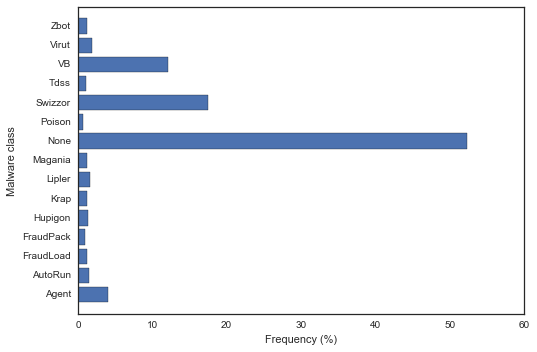

In [48]:
# convert into percentage
Y_train_percs = 100.0 * np.bincount(Y_train) / float(Y_train.shape[0])

# visualize distribution of categories in training set
plt.barh(list(range(15)), Y_train_percs, align='center')
plt.yticks(list(range(15)), labels)
plt.ylim(ymin=-1, ymax=15)
plt.ylabel('Malware class')
plt.xlabel('Frequency (%)')
plt.show()

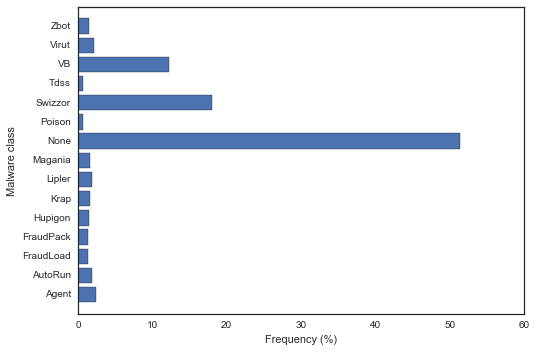

In [49]:
# convert into percentage
Y_valid_percs = 100.0 * np.bincount(Y_valid) / float(Y_valid.shape[0])

# visualize distribution of categories in training set
plt.barh(list(range(15)), Y_valid_percs, align='center')
plt.yticks(list(range(15)), labels)
plt.ylim(ymin=-1, ymax=15)
plt.ylabel('Malware class')
plt.xlabel('Frequency (%)')
plt.show()

**Create features for final predictions**

In [67]:
start = time.time()

# extract data for entire training set
X_train_all, Y_train_all, train_ids_all = create_data_matrix(
    fteng_fn=chosen_fteng_fn, direc=TRAIN_DIR, start_index=0, end_index=train_files)

# extract data for test set
X_test, Y_test, test_ids = create_data_matrix(
    fteng_fn=chosen_fteng_fn, direc=TEST_DIR, start_index=0, end_index=test_files)

print 'Training:', X_train_all.shape, Y_train_all.shape
print 'Test:', X_test.shape, Y_test.shape
print '----------'
print '%0.1f seconds runtime' % (time.time() - start)

Training: (3086, 210) (3086,)
Test: (3724, 210) (3724,)
----------
198.2 seconds runtime


<div class="alert alert-info">
<p><strong>PREDICTION MODELS</strong></p>
</div>

<div class="alert alert-danger">
<p><strong>Warning: the models below are set up to carry out a grid search over model parameters. Make sure you check the lists of parameters that are being passed before running! Default model parameters are included as comments.</strong></p>
</div>

**Logistic regression**

In [91]:
start = time.time()

# update model class and/or parameters to search over here
model = LogisticRegression()
penalties = ['l1', 'l2'] # default='l2' (only 2 options)
cs = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0] # default = 1.0

# cross-validation on training set to identify optimal parameters
model = grid_search(model, {'penalty': penalties, 'C': cs}, X_train, Y_train, show_results=True)

# fit model on training set with optimal parameters
# check out-of-sample performance using validation set
model, train_acc, test_acc = fit_model(model, X_train, Y_train, X_valid, Y_valid)

# fit model on entire training set with optimal parameters and make predictions
model, train_acc, test_acc = fit_model(model, X_train_all, Y_train_all, None, None, use_test=False)
Y_test_pred = model.predict(X_test)
write_predictions(Y_test_pred, test_ids, 'results/f05_logistic.csv')

print '%0.1f seconds runtime' % (time.time() - start)

# option to save fitted model
# joblib.dump(model, 'models/f05_logistic.pkl');

Grid scores
----------
mean: 0.64491, std: 0.02667, params: {'penalty': 'l1', 'C': 0.0001}
mean: 0.75139, std: 0.00853, params: {'penalty': 'l2', 'C': 0.0001}
mean: 0.72731, std: 0.00882, params: {'penalty': 'l1', 'C': 0.001}
mean: 0.75926, std: 0.00637, params: {'penalty': 'l2', 'C': 0.001}
mean: 0.76991, std: 0.03202, params: {'penalty': 'l1', 'C': 0.01}
mean: 0.76574, std: 0.03269, params: {'penalty': 'l2', 'C': 0.01}
mean: 0.83611, std: 0.02035, params: {'penalty': 'l1', 'C': 0.1}
mean: 0.76296, std: 0.02531, params: {'penalty': 'l2', 'C': 0.1}
mean: 0.84676, std: 0.00975, params: {'penalty': 'l1', 'C': 1.0}
mean: 0.76852, std: 0.03087, params: {'penalty': 'l2', 'C': 1.0}
mean: 0.84630, std: 0.01246, params: {'penalty': 'l1', 'C': 10.0}
mean: 0.76944, std: 0.02783, params: {'penalty': 'l2', 'C': 10.0}
mean: 0.85000, std: 0.00745, params: {'penalty': 'l1', 'C': 100.0}
mean: 0.75648, std: 0.00807, params: {'penalty': 'l2', 'C': 100.0}
mean: 0.85556, std: 0.01176, params: {'penalty': 

**Random forest classifier**

In [88]:
start = time.time()

# update model class and/or parameters to search over here
model = RandomForestClassifier()
estimators = [10, 50, 100, 150, 200, 250] # default = 10
features = [0.1, 0.25, 0.5, 0.75, 1.0, 'sqrt', 'log2'] # default = 'sqrt'
depths = [None] # default = None (i.e. ignored)
samples = [1, 5, 10, 25, 50, 100] # default = 1

# cross-validation on training set to identify optimal parameters
model = grid_search(model, {'n_estimators': estimators, 'max_features': features,
                            'max_depth': depths, 'min_samples_leaf': samples}, 
                    X_train, Y_train, show_results=True)

# fit model on training set with optimal parameters
# check out-of-sample performance using validation set
model, train_acc, test_acc = fit_model(model, X_train, Y_train, X_valid, Y_valid)

# fit model on entire training set with optimal parameters and make predictions
model, train_acc, test_acc = fit_model(model, X_train_all, Y_train_all, None, None, use_test=False)
Y_test_pred = model.predict(X_test)
write_predictions(Y_test_pred, test_ids, 'results/f05_random_forest.csv')

print '%0.1f seconds runtime' % (time.time() - start)

# option to save fitted model
# joblib.dump(model, 'models/f05_random_forest.pkl');

Grid scores
----------
mean: 0.87593, std: 0.00984, params: {'max_features': 0.1, 'n_estimators': 10, 'max_depth': None, 'min_samples_leaf': 1}
mean: 0.88935, std: 0.01164, params: {'max_features': 0.1, 'n_estimators': 50, 'max_depth': None, 'min_samples_leaf': 1}
mean: 0.89167, std: 0.00889, params: {'max_features': 0.1, 'n_estimators': 100, 'max_depth': None, 'min_samples_leaf': 1}
mean: 0.89074, std: 0.00975, params: {'max_features': 0.1, 'n_estimators': 150, 'max_depth': None, 'min_samples_leaf': 1}
mean: 0.89213, std: 0.01067, params: {'max_features': 0.1, 'n_estimators': 200, 'max_depth': None, 'min_samples_leaf': 1}
mean: 0.89167, std: 0.01312, params: {'max_features': 0.1, 'n_estimators': 250, 'max_depth': None, 'min_samples_leaf': 1}
mean: 0.87037, std: 0.00420, params: {'max_features': 0.1, 'n_estimators': 10, 'max_depth': None, 'min_samples_leaf': 5}
mean: 0.87222, std: 0.00561, params: {'max_features': 0.1, 'n_estimators': 50, 'max_depth': None, 'min_samples_leaf': 5}
mean:

**Extra trees classifier**

In [89]:
start = time.time()

# update model class and/or parameters to search over here
model = ExtraTreesClassifier()
estimators = [10, 50, 100, 150, 200, 250] # default = 10
features = [0.1, 0.25, 0.5, 0.75, 1.0, 'sqrt', 'log2'] # default = 'sqrt'
depths = [None] # default = None (i.e. ignored)
samples = [1, 5, 10, 25, 50, 100] # default = 1

# cross-validation on training set to identify optimal parameters
model = grid_search(model, {'n_estimators': estimators, 'max_features': features,
                            'max_depth': depths, 'min_samples_leaf': samples}, 
                    X_train, Y_train, show_results=True)

# fit model on training set with optimal parameters
# check out-of-sample performance using validation set
model, train_acc, test_acc = fit_model(model, X_train, Y_train, X_valid, Y_valid)

# fit model on entire training set with optimal parameters and make predictions
model, train_acc, test_acc = fit_model(model, X_train_all, Y_train_all, None, None, use_test=False)
Y_test_pred = model.predict(X_test)
write_predictions(Y_test_pred, test_ids, 'results/f05_extra_trees.csv')

print '%0.1f seconds runtime' % (time.time() - start)

# option to save fitted model
# joblib.dump(model, 'models/f05_extra_trees.pkl');

Grid scores
----------
mean: 0.87454, std: 0.01258, params: {'max_features': 0.1, 'n_estimators': 10, 'max_depth': None, 'min_samples_leaf': 1}
mean: 0.88426, std: 0.01261, params: {'max_features': 0.1, 'n_estimators': 50, 'max_depth': None, 'min_samples_leaf': 1}
mean: 0.88472, std: 0.01386, params: {'max_features': 0.1, 'n_estimators': 100, 'max_depth': None, 'min_samples_leaf': 1}
mean: 0.88704, std: 0.01197, params: {'max_features': 0.1, 'n_estimators': 150, 'max_depth': None, 'min_samples_leaf': 1}
mean: 0.88519, std: 0.01348, params: {'max_features': 0.1, 'n_estimators': 200, 'max_depth': None, 'min_samples_leaf': 1}
mean: 0.88611, std: 0.01364, params: {'max_features': 0.1, 'n_estimators': 250, 'max_depth': None, 'min_samples_leaf': 1}
mean: 0.86481, std: 0.01195, params: {'max_features': 0.1, 'n_estimators': 10, 'max_depth': None, 'min_samples_leaf': 5}
mean: 0.86759, std: 0.00646, params: {'max_features': 0.1, 'n_estimators': 50, 'max_depth': None, 'min_samples_leaf': 5}
mean:

**AdaBoost classifier**

In [90]:
start = time.time()

# update model class and/or parameters to search over here
model = AdaBoostClassifier()
estimators = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500] # default = 50
rates = [0.1, 0.25, 0.5, 0.75, 1.0] # default = 1.0

# cross-validation on training set to identify optimal parameters
model = grid_search(model, {'n_estimators': estimators, 'learning_rate': rates}, 
                    X_train, Y_train, show_results=True)

# fit model on training set with optimal parameters
# check out-of-sample performance using validation set
model, train_acc, test_acc = fit_model(model, X_train, Y_train, X_valid, Y_valid)

# fit model on entire training set with optimal parameters and make predictions
model, train_acc, test_acc = fit_model(model, X_train_all, Y_train_all, None, None, use_test=False)
Y_test_pred = model.predict(X_test)
write_predictions(Y_test_pred, test_ids, 'results/f05_adaboost.csv')

print '%0.1f seconds runtime' % (time.time() - start)

# option to save fitted model
# joblib.dump(model, 'models/f05_adaboost.pkl');

Grid scores
----------
mean: 0.53935, std: 0.03222, params: {'n_estimators': 50, 'learning_rate': 0.1}
mean: 0.54815, std: 0.03984, params: {'n_estimators': 100, 'learning_rate': 0.1}
mean: 0.54259, std: 0.03726, params: {'n_estimators': 150, 'learning_rate': 0.1}
mean: 0.52546, std: 0.00278, params: {'n_estimators': 200, 'learning_rate': 0.1}
mean: 0.52500, std: 0.00505, params: {'n_estimators': 250, 'learning_rate': 0.1}
mean: 0.50278, std: 0.02983, params: {'n_estimators': 300, 'learning_rate': 0.1}
mean: 0.49167, std: 0.03580, params: {'n_estimators': 350, 'learning_rate': 0.1}
mean: 0.48750, std: 0.03674, params: {'n_estimators': 400, 'learning_rate': 0.1}
mean: 0.50324, std: 0.04453, params: {'n_estimators': 450, 'learning_rate': 0.1}
mean: 0.49352, std: 0.06251, params: {'n_estimators': 500, 'learning_rate': 0.1}
mean: 0.52315, std: 0.00704, params: {'n_estimators': 50, 'learning_rate': 0.25}
mean: 0.51620, std: 0.00846, params: {'n_estimators': 100, 'learning_rate': 0.25}
mean: